# Pulsed system measurements
Using the switch as qubit excitation

## SETUP

In [32]:
# Header notebook
data_exp = {
    "Responsible": "Daniel G. Benvenutti",
    "setup": "Pulsed with switch directly on qubit",
    "sample": "2QTII",
}

### Import drivers
 The drivers are located in the folder Instruments

In [1]:
# drivers de controle dos instrumentos
from instruments.ATS9872_driver import * # alazar placa de aquisição
from instruments.DG645_driver import * # delay generator 
from instruments.M8195A_driver import * # awg
from instruments.E8257D_driver import * #RF source
from instruments.Agilent11713C_driver import * # attenuator
from instruments.SIM928_driver import * # Voltage source
from instruments.SIM970_driver import * # Voltage meter

### The measurement library is located at the measurements folder

In [3]:
from measurements.DataChannelManager import * # Contém classe que gerencia os dados para serem carregados no AWG
from measurements.PulseSequence import * # Classe que estratura e sequencia os pulsos

# Diferentes tipos de pulsos que podem ser usados

from measurements.waveforms.SquarePulse import *
from measurements.waveforms.ZeroPulse import *
from measurements.waveforms.GaussianPulse import *
from measurements.waveforms.DragPulse import *
from measurements.waveforms.SquareSideBandPulse import *
from measurements.waveforms.GaussianCosPulse import *
from measurements.waveforms.GaussianBorderCosPulse import *


### Auxiliary imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from time import sleep
from IPython.display import clear_output
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm


### Functions

In [69]:
def damped_cos(t, offset, amp, tau, period, phase):
    return offset + amp * np.exp(-t / tau) * np.cos(2 * np.pi / period * t + phase)


def exp_decay(t, offset, tau, amp):
    return offset + amp * np.exp(-t / tau)


def fit(Durat, Mag, func, p0):
    # data graph
    fig = go.Figure(go.Scatter(x=Durat, y=Mag, mode="lines+markers", name="Data"))
    try:  # atempts to fit the curve
        popt, pcov = curve_fit(
            func,
            Durat,
            Mag,
            p0=p0,
        )

    except Exception as e:
        print("Fit failed")
        print(e)
        empty = [np.nan] * len(func.__code__.co_varnames)
        popt, perr = (empty, empty)
    else:
        perr = np.sqrt(np.diag(pcov))
        t = np.linspace(Durat[0], Durat[-1], len(Durat) * 10)
        y = func(t, *popt)
        fig = fig.add_trace(go.Scatter(x=t, y=y, mode="lines", name="Fit"))

    fig.update_layout(height=600, width=700)
    dic_popt = {name: value for name, value in zip(func.__code__.co_varnames[1:], popt)}
    dic_perr = {name: value for name, value in zip(func.__code__.co_varnames[1:], perr)}

    return fig, dic_popt, dic_perr

### Configure the other Instruments

In [4]:
att_address='TCPIP0::169.254.101.101::inst0::INSTR'
RFsourceMeasurement_address='TCPIP0::169.254.101.103::inst0::INSTR'
RFsourceExcitation_address='TCPIP0::169.254.101.104::inst0::INSTR'
Voltsource_address='GPIB0::2::INSTR'
Voltsource_channel=8
Voltmeter_address='GPIB0::2::INSTR'
Voltmeter_channel=5
# alazar, placa de aquisição
inst_att = Agilent11713C_driver(att_address)
inst_RFsourceMeasurement = E8257D_driver(RFsourceMeasurement_address)
inst_RFsourceExcitation = E8257D_driver(RFsourceExcitation_address)
inst_voltsource =  SIM928_driver(Voltsource_address,Voltsource_channel,step_time=0.1,step_voltage=0.001)
inst_voltmeter = SIM970_driver(Voltmeter_address,Voltmeter_channel)

### Configura as fontes

In [7]:
# temos que configurar a fonte no modo de pulsos com trigger externo
# a polaridade escolhida da fonte depende do canal utilizado do awg.
# todo canal do awg é duplicado. Ele vai ter um canal normal e outro que idêntico ao normal só que invertido.
# A fonte de medida recebe o invertido enquando a placa alazar recebe o normal. Eu faço isso para
# manter o nível do trigger igual em ambos.
inst_RFsourceMeasurement.set_pulse_trigger_external()
inst_RFsourceMeasurement.setPulsePolarityInverted()
inst_RFsourceMeasurement.start_mod()


# A fonte de excitação recebe o canal 3 - marker 1 -  normal
inst_RFsourceExcitation.set_pulse_trigger_external()
inst_RFsourceExcitation.setPulsePolarityNormal()
inst_RFsourceExcitation.start_mod()

# Configuramos amplitude do sinal da fonte de medida. Ela tem que ser o suficiente para alimentar os mixers que heterodinagem.
# calculamos que seu valor deve ser 18 dBm.
inst_RFsourceMeasurement.set_amplitude(18)

# A fonte de excitação não é necessariamente usada no processo de medida da cavidade (a menos que se queira ver os deslocamento dispersivo de frequência)
# no caso sua amplitude é por volta de 11 dBm
#inst_RFsourceExcitation.set_amplitude(11)

In [8]:
# parar as fontes
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()


### Configurar AWG

In [129]:
inst_awg = M8195A_driver('169.254.101.100')

inst_awg.setSampleRate(64e9)

# tem que conectar também o awg a nossa referência de rubídio 10 MHz
inst_awg.setRefInClockExternal()  
inst_awg.setRefInClockFrequency(10e6)

# configura o awg para usar dois canais (um de excitação, outro de medida) e usar dois markers
# o canal 1 gerará o sinal de excitação I e o sinal de medida
# o canal 2 gerará o sinal de excitação Q
# o canal 3 será o marker 1 - para ligar a fonte 2, fonte de excitação
# o canal 4 será o marker 2 - para ligar a fonte 1, de medida, e para trigar a placa de aquisição alazar
inst_awg.setDualWithMarker()

# dividir a memória em 2
inst_awg.setMemoryDivision(2)
# usar a memória externa para o canal 2
inst_awg.setChannelMemoryToExtended(2)


# markers should have 1 V amplitude and offset 0.5
inst_awg.setVoltage(3,1) 
inst_awg.setVoltage(4,1)

inst_awg.setVoltageOffset(3,0.5) 
inst_awg.setVoltageOffset(4,0.5)

inst_awg.enableChanneloutput(1)
inst_awg.enableChanneloutput(2)
inst_awg.enableChanneloutput(3)
inst_awg.enableChanneloutput(4)

In [130]:
inst_awg.getError()

In [131]:
inst_awg.stop()

### Configurar Alazar

In [12]:
inst_alazar = ATS9872_driver()

alazar_params = {}

RFMeasurementLength = 5e-6 # Escolher a duração do pulso de medida

#
# Values that work for recordsPerBuffer and BuffersPerAcquisition
#                           25                    20
#                           100                   20
#                           500                   100
alazar_params['recordsPerBuffer'] = 500  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
alazar_params['powerReference_dBm'] = -8 # Intensidade do sinal de referência.
alazar_params['inputLoad'] = 50# impedância dos cabos. 
alazar_params['triggerLevel_volts'] = 0.7  # Level do trigger para ativar captura.
alazar_params['triggerRange_volts'] = 1            # Tamanho máximo do sinal do trigger.
alazar_params['waveformHeadCut'] = 1500 # quanto pontos iniciais por captura vão ser ignorados.
alazar_params['period'] = 4# for 20mhz???  - 14 # o período em pontos do sinal capturado ( 70 MHz -> 14 pontos).
alazar_params['buffer_timeout_ms'] = 5000 # tempo de espera para chegar um buffer; se ultrapassar, ocorre timeout.
alazar_params['decimation_value'] = 1 # valor de divisão do sampling rate.
alazar_params['TTL'] = True # Configuração do sinal de trigger. É o que funcionaou quando estava trigando pelo AWG. Quando é pelo delay generator, não usa isso.
alazar_params['save'] = False # Caso queira salvar todos os pontos adquiridos na aquisição em formato binário.


DefaultAlazarSamplingRate = 1e9
samplingRate =  DefaultAlazarSamplingRate/alazar_params['decimation_value']

# O número pontos por aquisição depende do sampling rate. Tem que ser múltiplos de 256.
alazar_params['postTriggerSamples'] = int(RFMeasurementLength*samplingRate/256)*256    # quantos pontos depois do trigger.
alazar_params['preTriggerSamples'] = 0 # quantos pontos o alazar vai salvar antes do trigger.

# função que retornar I e Q da placa alazar
#inst_alazar.capture(**alazar_params)

### Configurar DataChannel

In [134]:
ms = DataChannelManager(inst_awg)

ms.clearAwgChannel()

ms.labelAwgChannel(channel = 2, # o canal do awg
                        channelName = 'Q', markerValue = 1)

ms.labelAwgChannel(channel = 1, # o canal do awg
                        channelName = 'I', markerValue = 1)

ms.labelAwgChannel(channel = 1, # o canal do awg
                        channelName = 'm', markerValue = 2)

## SHARED PARAMETERS SETUP/UPDATE

In [31]:

# dictionary with the parameters of the experiment shared through the measurements
# come back here to update them
uni_params = {
    "measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": 18,  # dBm
    "attenuation": 60,  # dB
    "freq_qubit":4.4565e9, #Hz
    "pi_pulse_len":1.04950307e-06/2, #s
}
uni_params

{'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'attenuation': 60,
 'freq_qubit': 4456500000.0,
 'pi_pulse_len': 5.24751535e-07}

## Cavity

The main idea of this measure is to generate only one pulse. By scanning in frequency, the resonance of the cavity is obtained.

In [95]:
# Define-se um pulso Zero
p1 = ZeroPulse(length = RFMeasurementLength)
s1 = PulseSequence('Cavidade', 1e-6)
s1.clear()

s1.add(p = p1, channel = 'm')
s1.channels
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 100e-6)
print(ms._channelData)
inst_awg.freeMemory()
ms.allocAwgMemory()
# Para car
ms.loadChannelDataToAwg('m')
# Updates the marker of the excitation source
ms.setInstrumentsMarker(1)
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_awg.getError()

In [34]:
#EXPERIMENT PARAMETERS
parameters={
    "name":"Cavity",
    "attenuation":60, #dB
    "Freq":np.arange(7017,7023,0.1)*1e6 #Hz
}
#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}
parameters


{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'Cavity',
 'attenuation': 60,
 'Freq': array([7.0170e+09, 7.0171e+09, 7.0172e+09, 7.0173e+09, 7.0174e+09,
        7.0175e+09, 7.0176e+09, 7.0177e+09, 7.0178e+09, 7.0179e+09,
        7.0180e+09, 7.0181e+09, 7.0182e+09, 7.0183e+09, 7.0184e+09,
        7.0185e+09, 7.0186e+09, 7.0187e+09, 7.0188e+09, 7.0189e+09,
        7.0190e+09, 7.0191e+09, 7.0192e+09, 7.0193e+09, 7.0194e+09,
        7.0195e+09, 7.0196e+09, 7.0197e+09, 7.0198e+09, 7.0199e+09,
        7.0200e+09, 7.0201e+09, 7.0202e+09, 7.0203e+09, 7.0204e+09,
        7.0205e+09, 7.0206e+09, 7.0207e+09, 7.0208e+09, 7.0209e+09,
        7.0210e+09, 7.0211e+09, 7.0212e+09, 7.0213e+09, 7.0214e+09,
        7.0215e+09, 7.0216e+09, 7.0217e+09, 7.0218e+09, 7.0219e+09,
        7.0220e+09, 7.0221e+09, 7.0222e+09, 7.0223e+09, 7.0224e+09,
        7.0225e+09, 7.0226e+09, 7.0227e+09, 7.0228e+09, 7.0229e+09])}

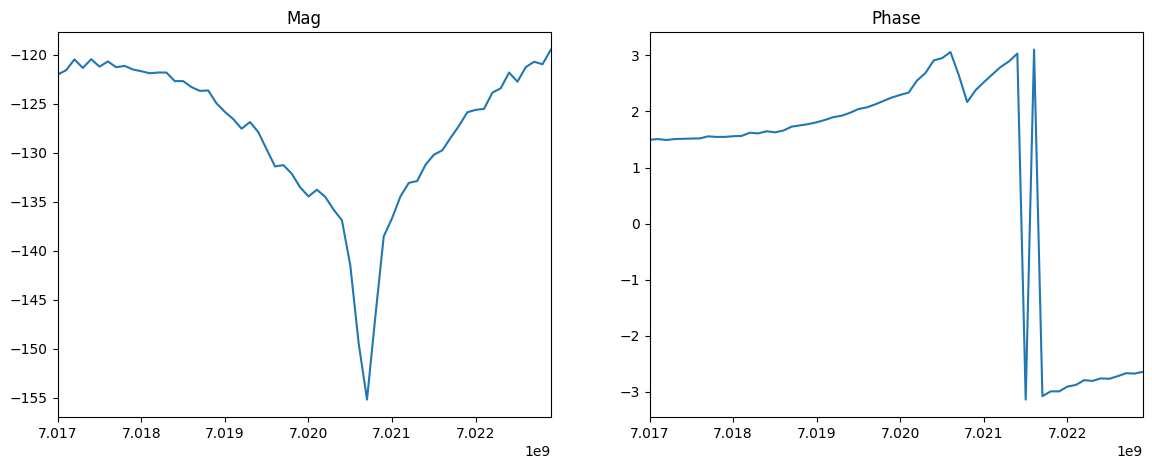

In [97]:
Freq=parameters["Freq"]
# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}_%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"



inst_att.set_attenuation(parameters["attenuation"])

alazar_params['recordsPerBuffer'] = 150  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.


Mag = np.full(len(Freq),np.nan)
Phase = np.full(len(Freq),np.nan)



inst_awg.start()
inst_RFsourceMeasurement.start_rf()
sleep(1)
pbar=tqdm(total=len(Freq))
for  i, freq in enumerate(Freq):

    inst_RFsourceMeasurement.set_frequency(freq-240e6)
    inst_RFsourceMeasurement.query('*OPC?') #synchronize instrument to python with a query
    #sleep(0.05)

    I,Q = inst_alazar.capture(**alazar_params)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    #plt.gcf().clear()
    clear_output(wait=True)  
    print(name)
    pbar.update(1)
    display(pbar.container)
    #plt.plot(Freq,Mag)

    # fig, ax = plt.subplots(1,2,figsize=(14, 5))
    # ax[1].set_xlim(Freq[0],Freq[-1])
    # ax[1].set_title("Phase")
    # ax[1].plot(Freq,Phase)
    # ax[0].set_xlim(Freq[0],Freq[-1])
    # ax[0].set_title("Mag")
    # ax[0].plot(Freq,Mag)
    # 
    # plt.pause(0.05)

    #plotly
    px.line(x=Freq,y=Mag,width=600,height=600).show()
    
    #plt.show()
    end=datetime.now()
    np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)

inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()

In [98]:
#finds minimum of the magnitude and corresponding Frequency
Freq[np.argmin(Mag)]

7020700000.000013

## PowerSweep

In [35]:
#EXPERIMENT PARAMETERS
parameters={
    "name":"MapPowerSweep",
    "Freq":np.arange(7018,7022.5,0.1)*1e6, #Hz
    "Att":np.array([10,20,50])#np.arange(45,70,5) #dB
}
#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}
parameters

{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'MapPowerSweep',
 'Freq': array([7.0180e+09, 7.0181e+09, 7.0182e+09, 7.0183e+09, 7.0184e+09,
        7.0185e+09, 7.0186e+09, 7.0187e+09, 7.0188e+09, 7.0189e+09,
        7.0190e+09, 7.0191e+09, 7.0192e+09, 7.0193e+09, 7.0194e+09,
        7.0195e+09, 7.0196e+09, 7.0197e+09, 7.0198e+09, 7.0199e+09,
        7.0200e+09, 7.0201e+09, 7.0202e+09, 7.0203e+09, 7.0204e+09,
        7.0205e+09, 7.0206e+09, 7.0207e+09, 7.0208e+09, 7.0209e+09,
        7.0210e+09, 7.0211e+09, 7.0212e+09, 7.0213e+09, 7.0214e+09,
        7.0215e+09, 7.0216e+09, 7.0217e+09, 7.0218e+09, 7.0219e+09,
        7.0220e+09, 7.0221e+09, 7.0222e+09, 7.0223e+09, 7.0224e+09]),
 'Att': array([10, 20, 50])}

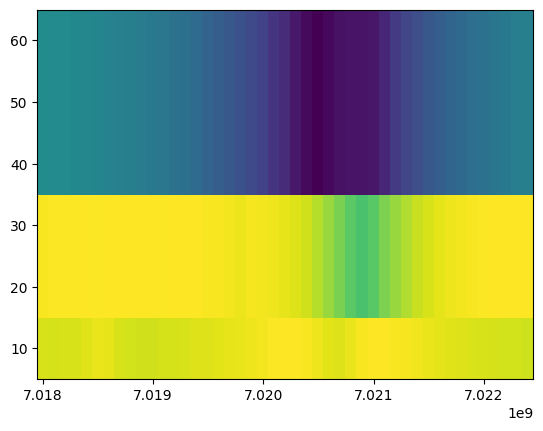

PowerSweep_2QTII__2024_10_05__16_29_18


In [24]:
Freq = parameters["Freq"]
Att = parameters["Att"]
inst_awg.stop()

p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Cavidade', 10e-9)

s1.clear()
s1.add(p = p2, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)
sleep(0.05)

inst_awg.start()
alazar_params['recordsPerBuffer'] = 200  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.

# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

Mag = np.full((len(Att), len(Freq)),np.nan)  #[[] for _ in range(len(freqs))]
Phase = np.full((len(Att), len(Freq)),np.nan)  #[[] for _ in range(len(freqs))]


inst_RFsourceMeasurement.start_rf()
inst_RFsourceMeasurement.query("*OPC?")
#sleep(1)

#Loop de Medidas
pbar=tqdm(total=len(Freq)*len(Att))
for  j, att in enumerate(Att):
#    inst_att.set_attenuation(att)
    inst_att.set_attenuation(att)
    for i, freq in enumerate(Freq):

        inst_RFsourceMeasurement.set_frequency(freq-240e6)
        inst_RFsourceMeasurement.query("*OPC?")
        #sleep(0.05)
    
        I,Q = inst_alazar.capture(**alazar_params)  
        Mag[j][i] = 20*np.log(np.sqrt(I**2+Q**2))
        Phase[j][i] = np.arctan2(Q, I)
    
        # Limpa o gráfico atual
        clear_output(wait=True)  
        print(name)
        pbar.update(1)
        display(pbar.container)
        
        #plt.pcolor(Freq,Att,Mag)
        #plt.pause(0.05)
       

        #plotly
        px.imshow(Mag,x=Freq,y=Att,aspect="auto",width=600,height=500).show()

        end=datetime.now()
        np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)

inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()

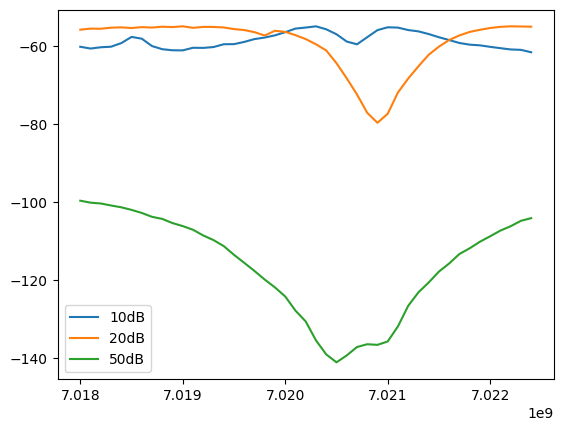

In [25]:
#plots graph as curves
for row,at in zip(Mag,Att):
    plt.plot(Freq,row, label=f"{at}dB")
plt.legend()

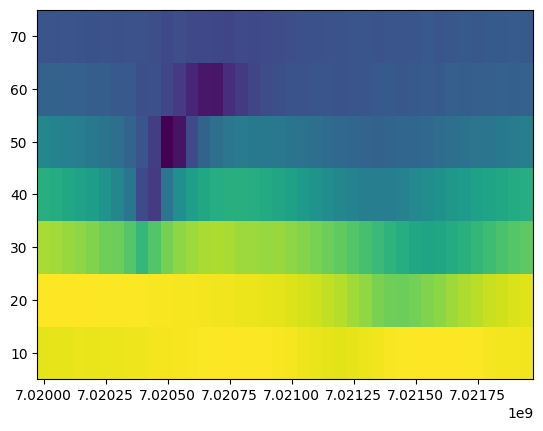

In [59]:
dados = np.load('PowerSweep_2QTII__2024_10_03__14_30_52.npz')
dados["header"]
attenuations = dados['Att']
Freq = dados['Freq']
mags = dados['Mag']
phases = dados['Phase']
plt.pcolor(Freq,attenuations,mags)

7020800000.000003


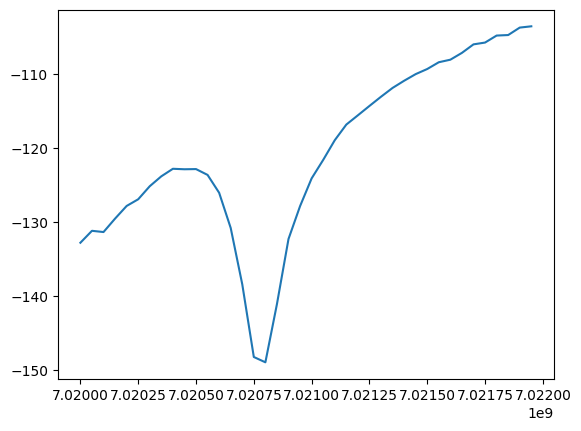

In [41]:
inds=np.where(Att==50)
print(Freq[np.argmin(Mag[inds[0][0],:])])
plt.plot(Freq,Mag[inds[0][0],:])

## TWOTONE

In [36]:
# EXPERIMENT PARAMETERS
parameters = {
    "name":"TwoTone",
    "attenuation": uni_params["attenuation"],  # dB
    #"attenuation": 60,  # dB
    "measurement_freq": uni_params["measurement_freq"], 
    #"measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": uni_params["measurement_amp"],   # dBm
    #"measurement_amp": 18,  # dBm
    "Freq":np.arange(4445, 4470, 0.5) * 1e6 #Hz
}
# adds data_exp to the parameters dict
parameters={**data_exp,**parameters}

# defines a generic pulse that can be adjusted here
def TwoTonePulse(freq):
    p1 = GaussianBorderCosPulse(
        length=7.0633001e-07, #s
        amplitude=0.6,
        sigma_factor=0.003,
        #border_lenght=6,
        frequency=freq,
    )
    # p1= GaussianCosPulse frequency = freq, amplitude = 0.4,sigma=1e-6/np.sqrt(np.pi))
    # p1= SquareSideBandPulse(length = 10e-6, frequency = freq, amplitude = 0.55)
    # p1= SquarePulse(length = 1e-6, amplitude = 1)
    # p1= GaussianPulse(length = 20e-6, amplitude = 1, sigma = 4e-6)
    return p1


# creates dict with pulse parameters
p1 = TwoTonePulse(0)
param_pulse={"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)
del param_pulse["frequency"] #removes the variable parameter
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_" + k: v for k, v in param_pulse.items()})

parameters

{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'TwoTone',
 'attenuation': 60,
 'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'Freq': array([4.4450e+09, 4.4455e+09, 4.4460e+09, 4.4465e+09, 4.4470e+09,
        4.4475e+09, 4.4480e+09, 4.4485e+09, 4.4490e+09, 4.4495e+09,
        4.4500e+09, 4.4505e+09, 4.4510e+09, 4.4515e+09, 4.4520e+09,
        4.4525e+09, 4.4530e+09, 4.4535e+09, 4.4540e+09, 4.4545e+09,
        4.4550e+09, 4.4555e+09, 4.4560e+09, 4.4565e+09, 4.4570e+09,
        4.4575e+09, 4.4580e+09, 4.4585e+09, 4.4590e+09, 4.4595e+09,
        4.4600e+09, 4.4605e+09, 4.4610e+09, 4.4615e+09, 4.4620e+09,
        4.4625e+09, 4.4630e+09, 4.4635e+09, 4.4640e+09, 4.4645e+09,
        4.4650e+09, 4.4655e+09, 4.4660e+09, 4.4665e+09, 4.4670e+09,
        4.4675e+09, 4.4680e+09, 4.4685e+09, 4.4690e+09, 4.4695e+09]),
 'pulse_type': 'GaussianBorderCosPulse',
 'pulse_length': 7.0633001e-07,
 'pulse_amplitude': 0.6,
 'p

In [62]:
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

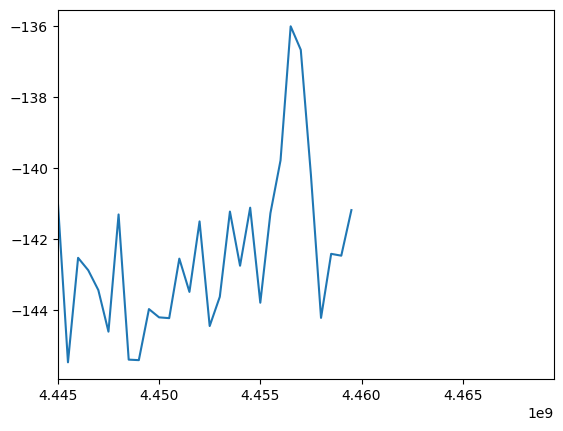

KeyboardInterrupt: 

In [144]:
Freq = parameters["Freq"]

start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}_ExctQubit_%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 100  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(parameters["attenuation"])
inst_RFsourceMeasurement.set_frequency(parameters["measurement_freq"]-240e6)
inst_RFsourceMeasurement.set_amplitude(parameters["measurement_amp"])
#inst_RFsourceExcitation.set_amplitude(11)

Mag = np.full(len(Freq),np.nan)
Phase = np.full(len(Freq),np.nan)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
#inst_RFsourceExcitation.start_rf()
sleep(1)

pbar=tqdm(total=len(Freq))
for  i, freq in enumerate(Freq):
################################ PULSE AWG
    inst_awg.stop()

    p1 = TwoTonePulse(freq)
    p2 = ZeroPulse(length = RFMeasurementLength)
    
    s1 = PulseSequence('Twotone', 10e-9)
    
    s1.clear()
    
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)
    
    inst_awg.freeMemory()
    
    ms.allocAwgMemory()
    sleep(0.05)
    ms.loadChannelDataToAwg('I')
    sleep(0.05)
    ms.loadChannelDataToAwg('m')
    sleep(0.05)
    
    # Atualiza o marker da fonte de excitação
    ms.setInstrumentsMarker(1)
    sleep(0.05)
    inst_awg.start()
    inst_RFsourceMeasurement.start_rf()
    sleep(1)
    ##########################################
    #sleep(0.05)

    I,Q = inst_alazar.capture(**alazar_params)  
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    clear_output(wait=True)  
    print(name)
    pbar.update(1)
    display(pbar.container)

    #plt.plot(Freq,Mag)
    #plt.xlim(Freq[0] ,Freq[-1])
    #plt.pause(0.05)
    

    #plotly
    px.line(x=Freq,y=Mag,width=600,height=600).show()
    end=datetime.now()
    np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)


inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
#inst_RFsourceExcitation.stop_rf()

TWOTONE_2QTII_ExctQubit_2024_10_03__15_34_16.npz


4456500000.0

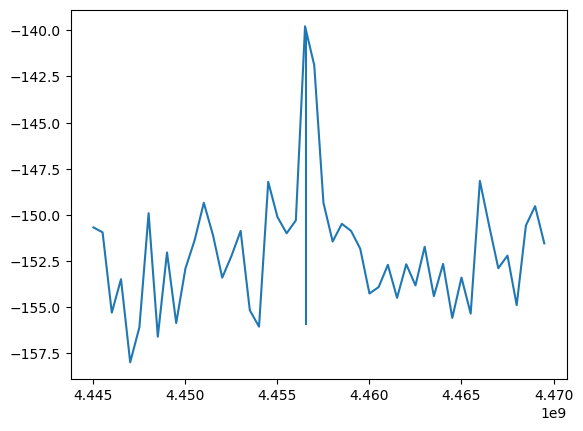

In [112]:
dados = np.load('TWOTONE_2QTII_ExctQubit_2024_10_05__17_59_45.npz')
dados["header"]
Freq = dados['Freq']
mags = dados['Mag']
phases = dados['Phase']
plt.plot(Freq,mags)
#plt.vlines(4.2961e9,-120,-130,color = 'red')
print('TWOTONE_2QTII_ExctQubit_2024_10_03__15_34_16.npz')

plt.vlines(4.45655e9,-156,-140)
Freq[np.argmax(mags)]

TWOTONE_2QTII_ExctQubit_2024_10_03__15_34_16.npz


4456500000.0

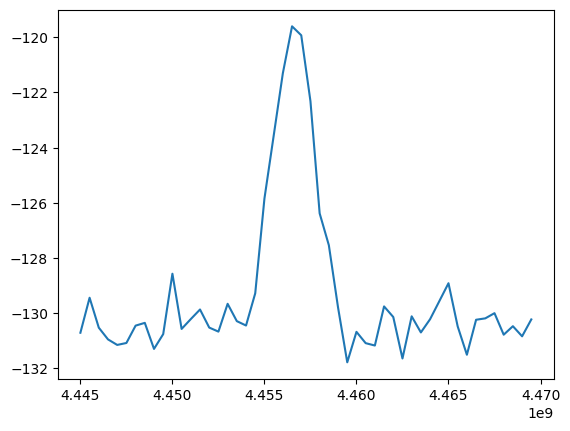

In [80]:
dados = np.load('TWOTONE_2QTII_ExctQubit_2024_10_04__22_04_56.npz')
dados["header"]
Freq = dados['Freq']
mags = dados['Mag']
phases = dados['Phase']
plt.plot(Freq,mags)
#plt.vlines(4.2961e9,-120,-130,color = 'red')
print('TWOTONE_2QTII_ExctQubit_2024_10_03__15_34_16.npz')
Freq[np.argmax(mags)]

## Power Sweep with qubit excitation

In [29]:
# EXPERIMENT PARAMETERS
parameters = {
    "name":"Cavity_ExctQubit",
    "attenuation": uni_params["attenuation"],  # dB
    #"attenuation": 60,  # dB
    "measurement_freq": uni_params["measurement_freq"], 
    #"measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": uni_params["measurement_amp"],   # dBm
    #"measurement_amp": 18,  # dBm
    "freq_qubit": uni_params["freq_qubit"],   # Hz
    #"freq_qubit":4.4565e9, #Hz
    "Freq":np.arange(7018,7022,0.1)*1e6, #Hz
}
# adds data_exp to the parameters dict
parameters={**data_exp,**parameters}

# defines a generic pulse that can be adjusted here
def ExctPulse():
    p1 = GaussianBorderCosPulse(
        length=1e-6, #s
        amplitude=0.6,
        sigma_factor=0.003,
        #border_lenght=6,
        frequency=parameters["freq_qubit"],
    )
    return p1


# creates dict with pulse parameters
p1 = ExctPulse()
param_pulse={"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_" + k: v for k, v in param_pulse.items()})

parameters

{'Responsavel': 'Daniel G. Benvenutti',
 'setup': 'VNA na cavidade',
 'sample': '2QTII',
 'name': 'Cavity_ExctQubit',
 'attenuation': 60,
 'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'freq_qubit': 4456500000.0,
 'Freq': array([7.0180e+09, 7.0181e+09, 7.0182e+09, 7.0183e+09, 7.0184e+09,
        7.0185e+09, 7.0186e+09, 7.0187e+09, 7.0188e+09, 7.0189e+09,
        7.0190e+09, 7.0191e+09, 7.0192e+09, 7.0193e+09, 7.0194e+09,
        7.0195e+09, 7.0196e+09, 7.0197e+09, 7.0198e+09, 7.0199e+09,
        7.0200e+09, 7.0201e+09, 7.0202e+09, 7.0203e+09, 7.0204e+09,
        7.0205e+09, 7.0206e+09, 7.0207e+09, 7.0208e+09, 7.0209e+09,
        7.0210e+09, 7.0211e+09, 7.0212e+09, 7.0213e+09, 7.0214e+09,
        7.0215e+09, 7.0216e+09, 7.0217e+09, 7.0218e+09, 7.0219e+09]),
 'pulse_length': 1e-06,
 'pulse_amplitude': 0.6,
 'pulse_sigma_factor': 0.003,
 'pulse_frequency': 4456500000.0,
 'pulse_phase': 0,
 'pulse_border_length': 3.5,
 'pulse_type': 'GaussianBorderCosPulse'}

In [ ]:
################################ PULSE AWG
inst_awg.stop()
p1 = ExctPulse()
s1 = PulseSequence("Twotone", 10e-9)
s1.clear()
s1.add(p=p1, channel="I", delay=RFMeasurementLength)

ms.prepareChannelData(sequence=s1, totalExperimentDuration=200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg("I")
sleep(0.05)
ms.loadChannelDataToAwg("m")
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)
sleep(0.05)
inst_awg.start()
sleep(0.05)

##########################################
s1.show_all()

    
Freq = parameters["Freq"]

start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(parameters["attenuation"])
#inst_RFsourceMeasurement.set_frequency(7.020899e9-70e6)
#inst_RFsourceExcitation.set_frequency(4.297e9)
inst_RFsourceMeasurement.set_amplitude(parameters["measurement_amp"])
#inst_RFsourceExcitation.set_amplitude(11)


Phase=np.full(len(Freq),np.nan)
Mag = np.full(len(Freq),np.nan)



#inst_awg.start()
inst_RFsourceMeasurement.start_rf()
#inst_RFsourceExcitation.start_rf()
sleep(1)

pbar=tqdm(total=len(Freq))
for  i, freq in enumerate(Freq):

    inst_RFsourceMeasurement.set_frequency(freq-240e6)
    sleep(0.05)

    I,Q = inst_alazar.capture(**alazar_params)  
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    clear_output(wait=True)  
    print(name)
    pbar.update(1)
    display(pbar.container)

    #plt.plot(Freq,Mag)
    #plt.xlim(Freq[0],Freq[-1])
    #plt.pause(0.05)
    
    #plotly
    px.line(x=Freq,y=Mag,width=600,height=600).show()
    
    end=datetime.now()
    np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)


inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

In [28]:
#cabecalho notebook
data_exp={
    "Responsavel":"Daniel G. Benvenutti",
    "setup":"VNA na cavidade",
    "sample":"2QTII",
}

TWOTONE_2QTII_ExctQubit_2024_08_29__20_36_14.npz


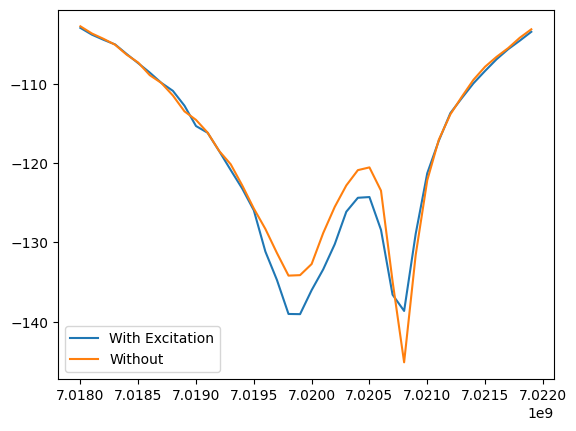

In [71]:
dados = np.load('TWOTONE_2QTII_ExctQubit_2024_10_04__16_28_39.npz')
dados["header"]
Freq = dados['Freq']
mags = dados['Mag']
phases = dados['Phase']
plt.plot(Freq,mags,label="With Excitation")
plt.plot(Freq,Mag,label="Without")
plt.legend()
print('TWOTONE_2QTII_ExctQubit_2024_08_29__20_36_14.npz')

In [930]:
mag6 = Mag

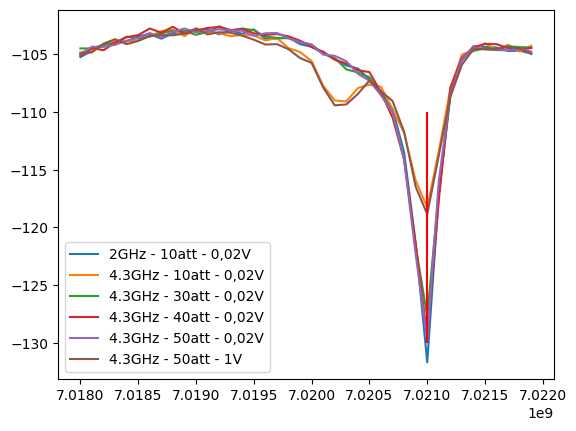

In [948]:
plt.plot(Freq,mag1,label = '2GHz - 10att - 0,02V')
plt.plot(Freq,mag2,label = '4.3GHz - 10att - 0,02V')
plt.plot(Freq,mag3,label = '4.3GHz - 30att - 0,02V')
plt.plot(Freq,mag4, label = '4.3GHz - 40att - 0,02V')
plt.plot(Freq,mag5, label = '4.3GHz - 50att - 0,02V')
plt.plot(Freq,mag6, label = '4.3GHz - 50att - 1V')
#plt.plot(Freq,np.array(mag7)+40, label = '4.3GHz-10att-0.2V')
#plt.plot(Freq,np.array(mag9)-40, label = '4.3GHz-10att-0.05V')
#plt.plot(Freq,np.array(mag10)-20, label = '4GHz-10att-0.1V')
#plt.plot(Freq,np.array(mag11)-20, label = '4.3GHz-10att-0.1V')
#plt.plot(Freq,np.array(mag9)-20, label = '4.3GHz-10att-0.05V')
plt.legend()
plt.vlines(7.021e9,-110,-130,color='red')

## Rabi

### Oscillation

In [37]:
#EXPERIMENT PARAMETERS 
parameters={
    "name":"Rabi",
    "attenuation": uni_params["attenuation"],  # dB
    #"attenuation": 60,  # dB
    "measurement_freq": uni_params["measurement_freq"], 
    #"measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": uni_params["measurement_amp"],   # dBm
    #"measurement_amp": 18,  # dBm
    "freq_qubit": uni_params["freq_qubit"],   # Hz
    #"freq_qubit":4.4565e9, #Hz
    "Durat":np.arange(0,4000e-9,200e-9), #s 
}
#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}



# defines a generic pulse that can be adjusted here
def RabiPulse(duration):
    p1 = GaussianBorderCosPulse(
        length=duration,
        amplitude=0.6,
        sigma_factor=0.003,
        #border_lenght=6,
        frequency=parameters["freq_qubit"], #Hz
    )
    return p1


# creates dict with pulse parameters
p1 = RabiPulse(0)
param_pulse={"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)
del param_pulse["length"] #removes the variable parameter
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_" + k: v for k, v in param_pulse.items()})
parameters


{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'Rabi',
 'attenuation': 60,
 'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'freq_qubit': 4456500000.0,
 'Durat': array([0.0e+00, 2.0e-07, 4.0e-07, 6.0e-07, 8.0e-07, 1.0e-06, 1.2e-06,
        1.4e-06, 1.6e-06, 1.8e-06, 2.0e-06, 2.2e-06, 2.4e-06, 2.6e-06,
        2.8e-06, 3.0e-06, 3.2e-06, 3.4e-06, 3.6e-06, 3.8e-06]),
 'pulse_type': 'GaussianBorderCosPulse',
 'pulse_amplitude': 0.6,
 'pulse_sigma_factor': 0.003,
 'pulse_frequency': 4456500000.0,
 'pulse_phase': 0,
 'pulse_border_length': 3.5}

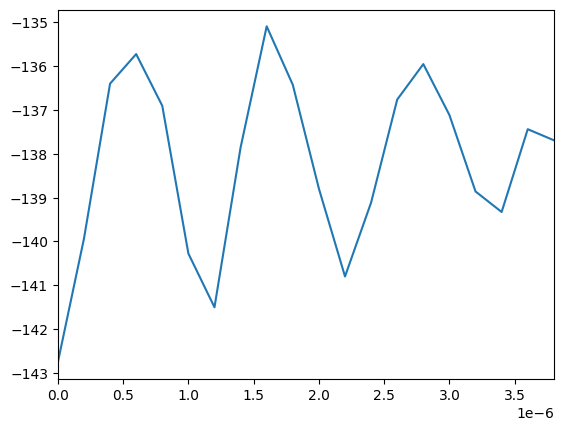

RABI_2QTII_ExctQubit_2024_10_06__08_58_42


In [145]:
Durat = parameters["Durat"]

start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}_ExctQubit_%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(parameters["attenuation"])
inst_RFsourceMeasurement.set_frequency(parameters["measurement_freq"]-240e6)
#inst_RFsourceExcitation.set_frequency(4.456500000e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(parameters["measurement_amp"])
#inst_RFsourceExcitation.set_amplitude(11)

Mag = np.full(len(Durat),np.nan)
Phase = np.full(len(Durat),np.nan)

############################### PULSE AWG
inst_awg.stop()
p1 = RabiPulse(0)
p2 = ZeroPulse(length = RFMeasurementLength)
s1 = PulseSequence('Twotone', 10e-9)
s1.clear()
s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()
ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)
sleep(0.05)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
#inst_RFsourceExcitation.start_rf()
sleep(1)

pbar=tqdm(total=len(Durat))
for i, duration in enumerate(Durat):

    inst_awg.stop()
    #p1 = GaussianBorderCosPulse(length = duration, frequency = 4.457e9, amplitude = 0.4,sigma=0.02*length, border_lenght=6)
    p1 = RabiPulse(duration)
    #p1 = SquarePulse(length = 1e-6, amplitude = 1)
    #p1 = GaussianPulse(length = 20e-6, amplitude = 1, sigma = 4e-6)
    p2 = ZeroPulse(length = RFMeasurementLength)

    s1 = PulseSequence('Twotone', 10e-9)

    s1.clear()

    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.updateChannelData(sequence = s1, totalExperimentDuration = 200e-6)

    inst_awg.freeMemory()

    ms.allocAwgMemory()
    sleep(0.05)
    ms.loadChannelDataToAwg('I')
    sleep(0.05)
    ms.loadChannelDataToAwg('m')
    sleep(0.05)

    # Atualiza o marker da fonte de excitação
    ms.setInstrumentsMarker(1)
    sleep(0.05)

    inst_awg.start()
    sleep(1)

    I,Q = inst_alazar.capture(**alazar_params)  
    sleep(0.5)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    clear_output(wait=True)  
    print(name)
    pbar.update(1)
    display(pbar.container)

    #plt.plot(Durat,Mag)
    #plt.xlim(Durat[0],Durat[-1])
    #plt.pause(0.05)
    
    #plotly
    px.line(x=Durat,y=Mag,width=600,height=600).show()

    end=datetime.now()
    np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)


inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

In [71]:
dados = np.load("RABI_2QTII_ExctQubit_2024_10_06__08_58_42.npz")
dados["header"]
Durat = dados["Durat"]
mags = dados["Mag"]
# mags = 10**(mags/20)
phases = dados["Phase"]

# Fit procedure
# prints function parameters
print(damped_cos.__code__.co_varnames)
# ('t', 'offset', 'amp', 'tau', 'period', 'phase')
# fits the function and creates a graph returning the parameters
fig, popt, perr = fit(Durat, mags, damped_cos, [-140, 4, 2e-6, 1e-6, 0])
# adds title etc to the figure and prints it
fig.update_layout(
    title="Rabi Oscillation <br>"
    f"$\\pi_{{pulse}}$={popt['period']/2:.2e}$\\pm${perr['period']/2:.2e} $\\mu$s",
    xaxis_title="Pulse duration (s)",
    yaxis_title="Magnitude (dBm)",
).show()
# print(popt,"\n",perr)

('t', 'offset', 'amp', 'tau', 'period', 'phase')


### Map

In [38]:
# EXPERIMENT PARAMETERS
freq_qubit = uni_params["freq_qubit"]
# freq_qubit=4.465e9 #Hz
parameters = {
    "name": "ChevronRabi",
    "attenuation": uni_params["attenuation"],  # dB
    # "attenuation": 60,  # dB
    "measurement_freq": uni_params["measurement_freq"],
    # "measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": uni_params["measurement_amp"],  # dBm
    # "measurement_amp": 18,  # dBm
    "freq_qubit": freq_qubit,  # Hz
    "Freq": np.arange(-1.5e6, 2e6, 0.1e6) + freq_qubit,  # Hz
    "Durat": np.arange(0, 6000e-9, 50e-9),  # s
}


# defines a generic pulse that can be adjusted here
def RabiMapPulse(duration, freq):
    p1 = GaussianBorderCosPulse(
        length=duration,
        amplitude=0.6,
        sigma_factor=0.003,
        # border_lenght=6,
        frequency=freq,  # Hz
    )
    return p1


# creates dict with pulse parameters
p1 = RabiMapPulse(0, 0)
param_pulse = {"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)
del param_pulse["frequency"]  # removes the variable parameter
del param_pulse["length"]  # removes the variable parameter
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_" + k: v for k, v in param_pulse.items()})

# adds data_exp to the parameters dict
parameters = {**data_exp, **parameters}

parameters

{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'ChevronRabi',
 'attenuation': 60,
 'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'freq_qubit': 4456500000.0,
 'Freq': array([4.4550e+09, 4.4551e+09, 4.4552e+09, 4.4553e+09, 4.4554e+09,
        4.4555e+09, 4.4556e+09, 4.4557e+09, 4.4558e+09, 4.4559e+09,
        4.4560e+09, 4.4561e+09, 4.4562e+09, 4.4563e+09, 4.4564e+09,
        4.4565e+09, 4.4566e+09, 4.4567e+09, 4.4568e+09, 4.4569e+09,
        4.4570e+09, 4.4571e+09, 4.4572e+09, 4.4573e+09, 4.4574e+09,
        4.4575e+09, 4.4576e+09, 4.4577e+09, 4.4578e+09, 4.4579e+09,
        4.4580e+09, 4.4581e+09, 4.4582e+09, 4.4583e+09, 4.4584e+09]),
 'Durat': array([0.00e+00, 5.00e-08, 1.00e-07, 1.50e-07, 2.00e-07, 2.50e-07,
        3.00e-07, 3.50e-07, 4.00e-07, 4.50e-07, 5.00e-07, 5.50e-07,
        6.00e-07, 6.50e-07, 7.00e-07, 7.50e-07, 8.00e-07, 8.50e-07,
        9.00e-07, 9.50e-07, 1.00e-06, 1.05e-06, 1.10e-06, 1

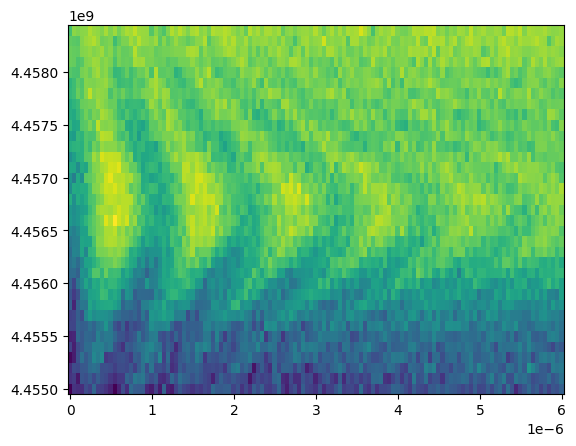

ChevronRabi_2QTII__2024_10_05__19_47_08


In [139]:
Freq=parameters["Freq"]
Durat=parameters["Durat"]
# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_RFsourceMeasurement.set_frequency(parameters["measurement_freq"]-240e6)

inst_att.set_attenuation(parameters["attenuation"])
#inst_RFsourceExcitation.set_frequency(4.2961e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(parameters["measurement_amp"])
#inst_RFsourceExcitation.set_amplitude(11)



Mag = np.full((len(Freq), len(Durat)),np.nan)  
Phase = np.full((len(Freq), len(Durat)),np.nan) 


inst_awg.stop()

p1 = RabiMapPulse(0,0)

p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)

s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)
sleep(0.05)
inst_awg.start()
inst_RFsourceMeasurement.start_rf()

#Loop de Medidas
pbar=tqdm(total=len(Freq)*len(Durat))
for  j, freq in enumerate(Freq):
    for i, duration in enumerate(Durat):
        inst_awg.stop()
        
        p1 = RabiMapPulse(duration,freq)
        p2 = ZeroPulse(length = RFMeasurementLength)

        s1 = PulseSequence('Twotone', 10e-9)

        s1.clear()

        s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
        s1.add(p = p2, channel = 'm')

        ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

        inst_awg.freeMemory()

        ms.allocAwgMemory()
        sleep(0.05)
        ms.loadChannelDataToAwg('I')
        sleep(0.05)
        ms.loadChannelDataToAwg('m')
        sleep(0.05)

        # Atualiza o marker da fonte de excitação
        ms.setInstrumentsMarker(1)
        sleep(0.05)
        inst_awg.start()
        sleep(1)

        I,Q = inst_alazar.capture(**alazar_params)  
        sleep(0.5)
        Mag[j][i] = 20*np.log(np.sqrt(I**2+Q**2))
        Phase[j][i] = np.arctan2(Q, I)
    
        # Limpa o gráfico atual
        clear_output(wait=True)  
        print(name)
        pbar.update(1)
        display(pbar.container)

        #plt.pcolor(Durat,Freq,Mag)
        #plt.pause(0.05)
        
        #plotly
        px.imshow(Mag,x=Durat,y=Freq,aspect="auto",width=600,height=500).show()
        
        end=datetime.now()
        np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)
        sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()


T1_2QTII__2024_10_04__18_39_34.npz


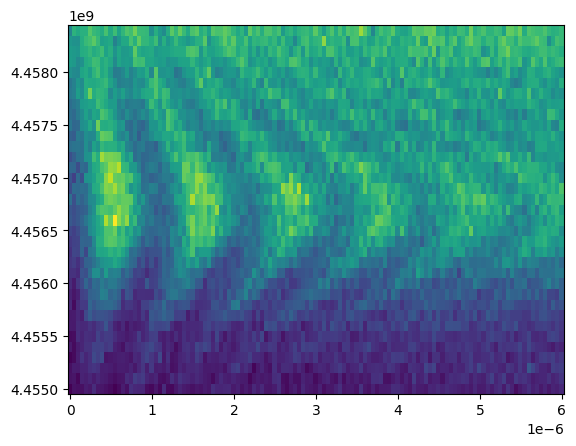

In [172]:
dados = np.load('ChevronRabi_2QTII__2024_10_05__19_47_08.npz')
Freq=dados["Freq"]
dados["header"]
Durat = dados['Durat']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']
#plt.plot(Durat,Mag[3,:])
plt.pcolor(Durat,Freq,Mag)
#plt.vlines(0.525e-6,-110,-130)
print('T1_2QTII__2024_10_04__18_39_34.npz')

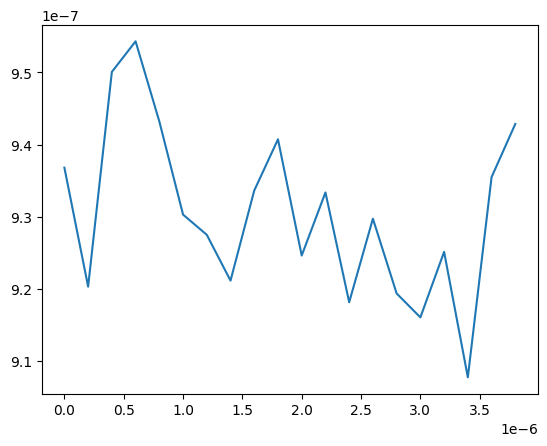

In [167]:
plt.plot(Durat,Mag[2])

## T1

In [39]:
#EXPERIMENT PARAMETERS 
parameters={
    "name":"T1",
    "attenuation": uni_params["attenuation"],  # dB
    #"attenuation": 60,  # dB
    "measurement_freq": uni_params["measurement_freq"], 
    #"measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": uni_params["measurement_amp"],   # dBm
    #"measurement_amp": 18,  # dBm
    "freq_qubit": uni_params["freq_qubit"],  # Hz
    #"freq_qubit" : 4.4565e9, #Hz
    "pi_pulse_len":uni_params["pi_pulse_len"], #s
    #"pi_pulse_len":7e-7, #s
    "Durat" : np.arange(0,4000e-9,200e-9), #s
}
#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}

# defines a generic pulse that can be adjusted here
def PiPulse():
    p1 = GaussianBorderCosPulse(
        length=parameters["pi_pulse_len"],
        amplitude=0.6,
        sigma_factor=0.003,
        #border_lenght=6,
        frequency=parameters["freq_qubit"], #Hz
    )
    return p1


# creates dict with pulse parameters
p1 = PiPulse()
param_pulse={"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)

del param_pulse["length"] #removes the variable parameter
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_" + k: v for k, v in param_pulse.items()})
parameters

{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'T1',
 'attenuation': 60,
 'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'freq_qubit': 4456500000.0,
 'pi_pulse_len': 5.24751535e-07,
 'Durat': array([0.0e+00, 2.0e-07, 4.0e-07, 6.0e-07, 8.0e-07, 1.0e-06, 1.2e-06,
        1.4e-06, 1.6e-06, 1.8e-06, 2.0e-06, 2.2e-06, 2.4e-06, 2.6e-06,
        2.8e-06, 3.0e-06, 3.2e-06, 3.4e-06, 3.6e-06, 3.8e-06]),
 'pulse_type': 'GaussianBorderCosPulse',
 'pulse_amplitude': 0.6,
 'pulse_sigma_factor': 0.003,
 'pulse_frequency': 4456500000.0,
 'pulse_phase': 0,
 'pulse_border_length': 3.5}

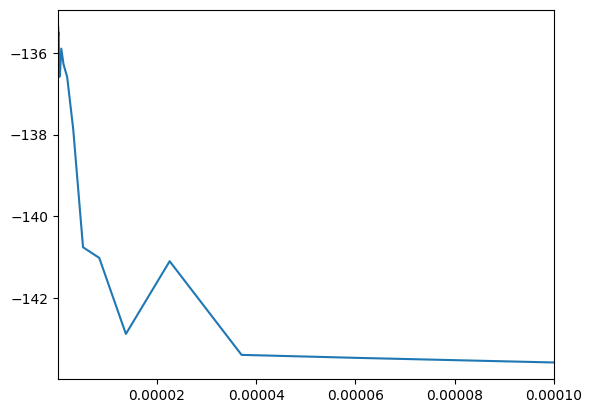

T1_2QTII__2024_10_06__09_08_09


In [153]:
Durat=parameters["Durat"]
# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(F"{data_exp["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    attenuations = data['Att']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(60)
inst_RFsourceMeasurement.set_frequency(7.0207e9-240e6)
#inst_RFsourceExcitation.set_frequency(4.456500000e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(18)
#inst_RFsourceExcitation.set_amplitude(11)


Delay=np.logspace(np.log10(8e-9), np.log10(100e-6), num=20)

Mag = np.full(len(Delay),np.nan)  
Phase = np.full(len(Delay),np.nan) 



inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()
sleep(0.5)
# Define-se um pulso Zero

p1 = PiPulse()
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)
s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)
sleep(2)
inst_awg.freeMemory()
sleep(0.5)
ms.allocAwgMemory()
sleep(0.5)
ms.loadChannelDataToAwg('I')
sleep(0.5)
ms.loadChannelDataToAwg('m')
sleep(0.5)
ms.setInstrumentsMarker(1)
sleep(0.5)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
#inst_RFsourceExcitation.start_rf()
sleep(1)

#Loop de Medidas
pbar=tqdm(total=len(Delay))
for i, delay in enumerate(Delay):

    s1.clear()
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength+delay)
    s1.add(p = p2, channel = 'm')
    ms.updateChannelData(sequence = s1, channelName = 'I')
    sleep(0.5)
    ms.loadChannelDataToAwg('I') # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)

    I,Q = inst_alazar.capture(**alazar_params)  
    sleep(0.5)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    clear_output(wait=True)  
    print(name)
    pbar.update(1)
    display(pbar.container)

   
    #plt.xlim(Delay[0],Delay[-1])
    #plt.plot(Delay,Mag)
    #plt.pause(0.05)
    
    #plotly
    px.line(x=Delay,y=Mag,width=600,height=600).show()

    end=datetime.now()
    np.savez(name,header=howtoplot,Delay=Delay,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)
    sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()

In [128]:
dados = np.load('T1_2QTII__2024_10_06__09_08_09.npz')
dados["header"]
Delay = dados['Delay']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']


print(exp_decay.__code__.co_varnames)
#('t', 'offset', 'tau', 'amp')
fit(Delay, Mag,exp_decay, [-140, 20e-6, 4,])

('t', 'offset', 'tau', 'amp')


({'offset': 6.959893886102248e-08,
  'tau': 5.612045226484689e-06,
  'amp': 9.273545556882353e-08},
 {'offset': 4.8622931030307e-09,
  'tau': 1.1116655087091844e-06,
  'amp': 5.562487644755729e-09})

ChevronRabi_3QTII__2024_08_30__15_01_17.npz


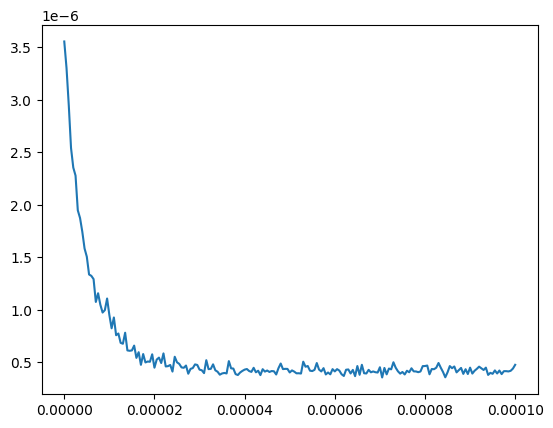

In [1157]:
dados = np.load('ChevronRabi_3QTII__2024_08_30__15_01_17.npz')
dados["header"]
Delay = dados['Delay']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']
plt.plot(Delay,Mag)
#plt.vlines(0.525e-6,-110,-130)
print('ChevronRabi_3QTII__2024_08_30__15_01_17.npz')

## Ramsey

### Oscillation

In [41]:
#EXPERIMENT PARAMETERS 
parameters={
    "name":"T2",
    "attenuation": uni_params["attenuation"],  # dB
    #"attenuation": 60,  # dB
    "measurement_freq": uni_params["measurement_freq"], 
    #"measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": uni_params["measurement_amp"],   # dBm
    #"measurement_amp": 18,  # dBm 
    "freq_qubit": uni_params["freq_qubit"],   # Hz
    #"freq_qubit":4.4565e9, #Hz
    "pi_pulse_len":uni_params["pi_pulse_len"], #s
    #"pi_pulse_len":7e-7, #s
    "Detuning":0, #Hz
    "Delay":np.arange(0,0.5e-6,15e-9), #s
}
#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}

# defines a generic pulse that can be adjusted here
def PiOver2Pulse():
    p1 = GaussianBorderCosPulse(
        length=parameters["pi_pulse_len"]/2,
        amplitude=0.6,
        sigma_factor=0.003,
        #border_lenght=6,
        frequency=parameters["freq_qubit"]+parameters["Detuning"], #Hz
    )
    return p1

# creates dict with pulse parameters
p1 = PiOver2Pulse()
param_pulse={"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_" + k: v for k, v in param_pulse.items()})
parameters

{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'T2',
 'attenuation': 60,
 'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'freq_qubit': 4456500000.0,
 'pi_pulse_len': 5.24751535e-07,
 'Detuning': 0,
 'Delay': array([0.00e+00, 1.50e-08, 3.00e-08, 4.50e-08, 6.00e-08, 7.50e-08,
        9.00e-08, 1.05e-07, 1.20e-07, 1.35e-07, 1.50e-07, 1.65e-07,
        1.80e-07, 1.95e-07, 2.10e-07, 2.25e-07, 2.40e-07, 2.55e-07,
        2.70e-07, 2.85e-07, 3.00e-07, 3.15e-07, 3.30e-07, 3.45e-07,
        3.60e-07, 3.75e-07, 3.90e-07, 4.05e-07, 4.20e-07, 4.35e-07,
        4.50e-07, 4.65e-07, 4.80e-07, 4.95e-07]),
 'pulse_type': 'GaussianBorderCosPulse',
 'pulse_length': 2.623757675e-07,
 'pulse_amplitude': 0.6,
 'pulse_sigma_factor': 0.003,
 'pulse_frequency': 4456500000.0,
 'pulse_phase': 0,
 'pulse_border_length': 3.5}

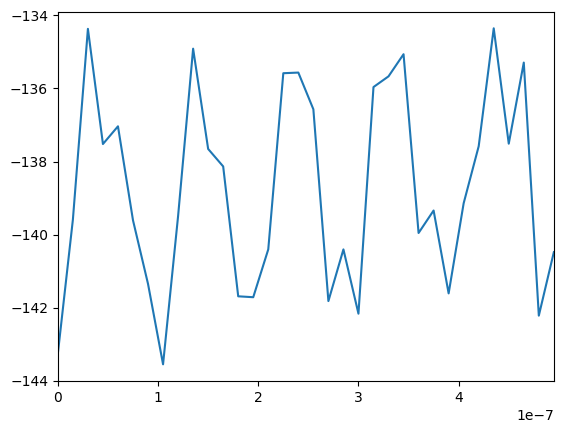

T2_2QTII__2024_10_06__09_18_04


In [160]:
Delay = parameters["Delay"]

# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    delays = data['Delay']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(parameters["attenuation"])
inst_RFsourceMeasurement.set_frequency(parameters["measurement_freq"]-240e6)
#inst_RFsourceExcitation.set_frequency(4.2961e9+0.0005e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(parameters["measurement_amp"])
#inst_RFsourceExcitation.set_amplitude(11)



Mag = np.full(len(Delay),np.nan)  
Phase = np.full(len(Delay),np.nan) 



inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
#inst_RFsourceExcitation.stop_rf()
sleep(0.5)
# Define-se um pulso Zero
p1 = PiOver2Pulse()
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)
s1.clear()

s1.add(p = p1, channel = 'I', delay = 0)#+PiPulse/2)
s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)
sleep(2)
inst_awg.freeMemory()
sleep(0.5)
ms.allocAwgMemory()
sleep(0.5)
ms.loadChannelDataToAwg('I')
sleep(0.5)
ms.loadChannelDataToAwg('m')
sleep(0.5)
ms.setInstrumentsMarker(1)
sleep(0.5)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
#inst_RFsourceExcitation.start_rf()
sleep(1)

#Loop de Medidas
pbar=tqdm(total=len(Delay))
for i, delay in enumerate(Delay):
    
    s1.clear()
    s1.add(p = p1, channel = 'I', delay =delay)#+PiPulse/2)
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')
    ms.updateChannelData(sequence = s1, channelName = 'I')
    sleep(0.5)
    ms.loadChannelDataToAwg('I') # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)

    I,Q = inst_alazar.capture(**alazar_params)  
    sleep(0.5)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
   
    clear_output(wait=True)  
    print(name)
    pbar.update(1)
    display(pbar.container)

    #plt.xlim(Delay[0],Delay[-1])
    #plt.plot(Delay,Mag)
    #plt.pause(0.05)
   
    #plotly
    px.line(x=Delay,y=Mag,width=600,height=600).show()

    np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)
    sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()
print(name)

In [147]:
dados = np.load('T2_2QTII__2024_10_06__09_18_04.npz')
dados["header"]
Delay = dados['Delay']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']
#px.line(x=Delay,y=Mag,width=600,height=600).show()
print(damped_cos.__code__.co_varnames)
#('t', 'offset', 'amp', 'tau', 'period', 'phase')
fit(Delay, Mag,damped_cos, [2e-7, 1e-7,2e-7, 2e-7, 0])

('t', 'offset', 'amp', 'tau', 'period', 'phase')


({'offset': 1.2266424043812307e-07,
  'amp': -4.921729508472652e-08,
  'tau': 2.499805447177666e-06,
  'period': 9.889956847077287e-08,
  'phase': 0.5067592798691269},
 {'offset': 3.807079623709469e-09,
  'amp': 1.090812165745965e-08,
  'tau': 5.00067955049401e-06,
  'period': 1.3088666351928603e-09,
  'phase': 0.22565667381631402})

C:\Users\Franscisco Rouxinol\AppData\Local\Temp\ipykernel_17476\4143396187.py:59: RuntimeWarning: overflow encountered in exp
  return (Const + Slope*np.exp(-time/Tr)*np.cos( (2*np.pi*time/period) + Phase))


(2.5, 5.0)

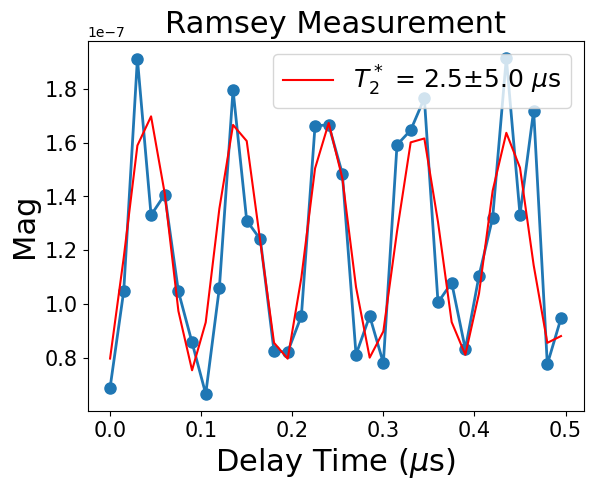

In [169]:
#(time, Const, Slope,Tr,freq,Phase)
chute = [1, 2,1e-6,0.2e-6,0]
Plot_Ramsey(Delay,Mag, chute)

### Ramsey Map

In [42]:
#EXPERIMENT PARAMETERS 
freq_qubit=uni_params["freq_qubit"]
parameters={
    "name":"ChevronRamsey",
    "attenuation": uni_params["attenuation"],  # dB
    #"attenuation": 60,  # dB
    "measurement_freq": uni_params["measurement_freq"], 
    #"measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": uni_params["measurement_amp"],   # dBm
    #"measurement_amp": 18,  # dBm 
    "pi_pulse_len":uni_params["pi_pulse_len"], #s
    #"pi_pulse_len":7e-7, #s
    "Detuning":0,#Hz
    "Freq" : np.arange(freq_qubit-2.5e6,freq_qubit+3e6,0.1e6), #Hz
    "Delay" : np.arange(0,0.5e-6,10e-9), #s
}
#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}



# defines a generic pulse that can be adjusted here
def DetunedPiOver2Pulse(freq):
    p1 = GaussianBorderCosPulse(
        length=parameters["pi_pulse_len"]/2,
        amplitude=0.6,
        sigma_factor=0.003,
        #border_lenght=6,
        frequency=freq, #Hz
    )
    return p1

# creates dict with pulse parameters
p1 = DetunedPiOver2Pulse(0)
param_pulse={"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)

del param_pulse["frequency"] #removes the variable parameter
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_" + k: v for k, v in param_pulse.items()})
parameters

{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'ChevronRamsey',
 'attenuation': 60,
 'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'pi_pulse_len': 5.24751535e-07,
 'Detuning': 0,
 'Freq': array([4.4540e+09, 4.4541e+09, 4.4542e+09, 4.4543e+09, 4.4544e+09,
        4.4545e+09, 4.4546e+09, 4.4547e+09, 4.4548e+09, 4.4549e+09,
        4.4550e+09, 4.4551e+09, 4.4552e+09, 4.4553e+09, 4.4554e+09,
        4.4555e+09, 4.4556e+09, 4.4557e+09, 4.4558e+09, 4.4559e+09,
        4.4560e+09, 4.4561e+09, 4.4562e+09, 4.4563e+09, 4.4564e+09,
        4.4565e+09, 4.4566e+09, 4.4567e+09, 4.4568e+09, 4.4569e+09,
        4.4570e+09, 4.4571e+09, 4.4572e+09, 4.4573e+09, 4.4574e+09,
        4.4575e+09, 4.4576e+09, 4.4577e+09, 4.4578e+09, 4.4579e+09,
        4.4580e+09, 4.4581e+09, 4.4582e+09, 4.4583e+09, 4.4584e+09,
        4.4585e+09, 4.4586e+09, 4.4587e+09, 4.4588e+09, 4.4589e+09,
        4.4590e+09, 4.4591e+09, 4.4592e+09, 4.45

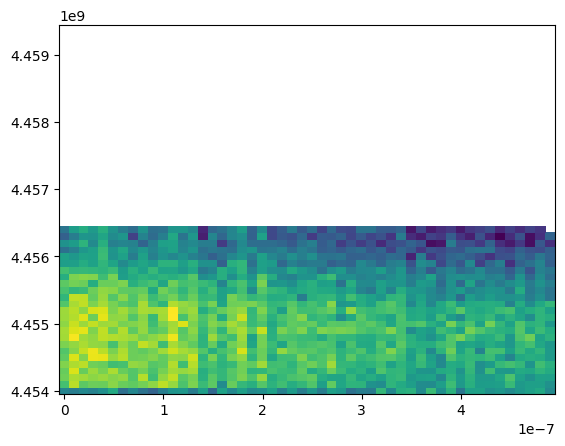

KeyboardInterrupt: 

In [140]:
Freq = parameters["Freq"]
Delay =  parameters["Delay"]
# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    Delays = data['Delay']\n\
    freqs = data['Freq']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 150  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(60)
inst_RFsourceMeasurement.set_frequency(7.0207e9-240e6)
#inst_RFsourceExcitation.set_frequency(4.2961e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(18)
#inst_RFsourceExcitation.set_amplitude(11)


Mag = np.full((len(Freq), len(Delay)),np.nan)  
Phase = np.full((len(Freq), len(Delay)),np.nan) 

    
inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()

ms.clearAwgChannel()
ms.labelAwgChannel(channel = 2, # o canal do awg
                        channelName = 'Q', markerValue = 1)

ms.labelAwgChannel(channel = 1, # o canal do awg
                        channelName = 'I', markerValue = 1)

ms.labelAwgChannel(channel = 1, # o canal do awg
                        channelName = 'm', markerValue = 2)


inst_RFsourceMeasurement.start_rf()
#    inst_RFsourceExcitation.start_rf()
sleep(1)


#Loop de Medidas
pbar=tqdm(total=len(Freq)*len(Delay))
for  j, freq in enumerate(Freq):
    inst_awg.stop()
    p1 = DetunedPiOver2Pulse(freq)
    p2 = ZeroPulse(length = RFMeasurementLength)

    s1 = PulseSequence('Twotone', 10e-9)
    s1.clear()

    s1.add(p = p1, channel = 'I', delay =delay)#+PiPulse/2)
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)
    sleep(2)
    inst_awg.freeMemory()
    sleep(0.5)
    ms.allocAwgMemory()
    sleep(0.5)
    ms.loadChannelDataToAwg('I')
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)
    inst_awg.start()
    for i, delay in enumerate(Delay):
        s1.clear()
        s1.add(p = p1, channel = 'I', delay = delay)#+PiPulse/2)
        s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
        s1.add(p = p2, channel = 'm')
        ms.updateChannelData(sequence = s1, channelName = 'I')
        sleep(0.5)
        ms.loadChannelDataToAwg('I') # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m
        sleep(0.5)
        ms.loadChannelDataToAwg('m')
        sleep(0.5)
        ms.setInstrumentsMarker(1)
        sleep(0.5)
    
        I,Q = inst_alazar.capture(**alazar_params)  
        sleep(0.5)
        Mag[j][i] = 20*np.log(np.sqrt(I**2+Q**2))
        Phase[j][i] = np.arctan2(Q, I)
    
        # Limpa o gráfico atual
        #plt.gcf().clear()
        clear_output(wait=True)  
        print(name)
        pbar.update(1)
        display(pbar.container)
        #plt.plot(Freq,Mag)
    
        #fig, ax = plt.subplots(1,2,figsize=(14, 5))
        #ax[1].set_title("Phase")
        #ax[1].plot(Freq,Phase)
        #ax[0].set_title("Mag")
        #ax[0].plot(Freq,Mag)
        #plt.pcolor(Delay,Freq,Mag)
        #plt.pause(0.05)

        #plotly
        px.imshow(Mag,x=Delay,y=Freq,aspect="auto",width=600,height=500).show()

        end=datetime.now()
        np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)
        sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()
print(name)

T2_3QTII__2024_08_30__16_30_50.npz


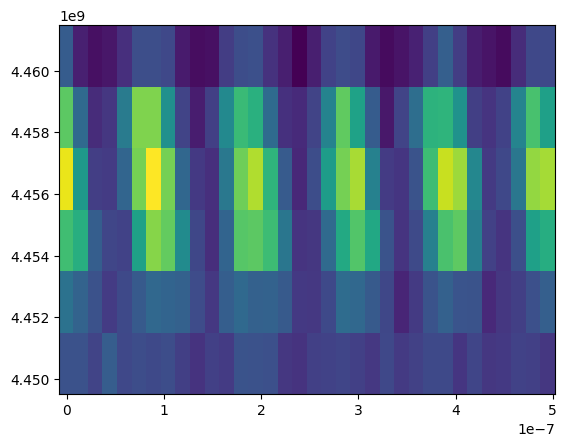

In [142]:
dados = np.load('ChevronRamsey_2QTII__2024_10_05__11_47_20.npz')
dados["header"]
Delay = dados['Delay']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']
plt.pcolor(Delay,Freq,Mag)
#plt.vlines(0.525e-6,-110,-130)
print('T2_3QTII__2024_08_30__16_30_50.npz')

6


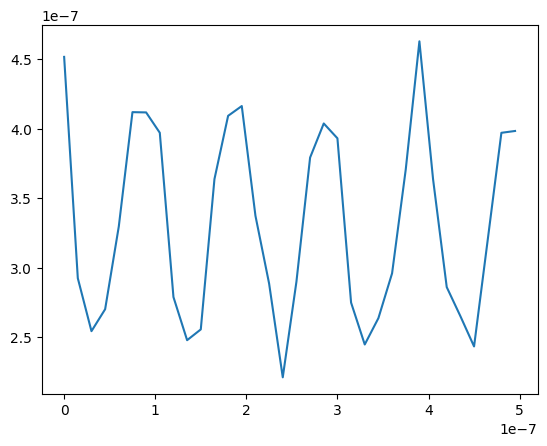

In [148]:
print(len(Mag))
plt.plot(Delay,Mag[5])

## Echo

In [43]:
#EXPERIMENT PARAMETERS 
parameters={
    "name":"T2e",
    "attenuation": uni_params["attenuation"],  # dB
    #"attenuation": 60,  # dB
    "measurement_freq": uni_params["measurement_freq"], 
    #"measurement_freq": 7.02070e9,  # Hz
    "measurement_amp": uni_params["measurement_amp"],   # dBm
    #"measurement_amp": 18,  # dBm
    "freq_qubit": uni_params["freq_qubit"],   # Hz
    #"freq_qubit":4.4565e9, #Hz
    "pi_pulse_len":uni_params["pi_pulse_len"], #s
    #"pi_pulse_len":7e-7, #s
    "Detuning":0, #Hz
    "Delay":np.arange(0,50e-6,1000e-9), #s
    #"Delay":np.logspace(np.log10(8e-9), np.log10(50e-6), num=20), #s
}
#adds data_exp to the parameters dict
parameters={**data_exp,**parameters}

# defines a generic pulse that can be adjusted here
def PiPulse():
    p1 = GaussianBorderCosPulse(
        length=parameters["pi_pulse_len"],
        amplitude=0.6,
        sigma_factor=0.003,
        #border_lenght=6,
        frequency=parameters["freq_qubit"]+parameters["Detuning"], #Hz
    )
    return p1

# defines a generic pulse that can be adjusted here
def PiOver2Pulse():
    p1 = GaussianBorderCosPulse(
        length=parameters["pi_pulse_len"]/2,
        amplitude=0.6,
        sigma_factor=0.003,
        #border_lenght=6,
        frequency=parameters["freq_qubit"]+parameters["Detuning"], #Hz
    )
    return p1

# creates dict with pulse parameters
p1 = PiPulse()
param_pulse={"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_pi_" + k: v for k, v in param_pulse.items()})

p1 = PiOver2Pulse()
param_pulse={"type": p1.__class__.__name__}
param_pulse.update(p1.__dict__)
# adds pulse" parameters to parameter dict with "pulse_" prefix
parameters.update({"pulse_pio2_" + k: v for k, v in param_pulse.items()})

parameters

{'Responsible': 'Daniel G. Benvenutti',
 'setup': 'Pulsed with switch directly on qubit',
 'sample': '2QTII',
 'name': 'T2e',
 'attenuation': 60,
 'measurement_freq': 7020700000.0,
 'measurement_amp': 18,
 'freq_qubit': 4456500000.0,
 'pi_pulse_len': 5.24751535e-07,
 'Detuning': 0,
 'Delay': array([0.0e+00, 1.0e-06, 2.0e-06, 3.0e-06, 4.0e-06, 5.0e-06, 6.0e-06,
        7.0e-06, 8.0e-06, 9.0e-06, 1.0e-05, 1.1e-05, 1.2e-05, 1.3e-05,
        1.4e-05, 1.5e-05, 1.6e-05, 1.7e-05, 1.8e-05, 1.9e-05, 2.0e-05,
        2.1e-05, 2.2e-05, 2.3e-05, 2.4e-05, 2.5e-05, 2.6e-05, 2.7e-05,
        2.8e-05, 2.9e-05, 3.0e-05, 3.1e-05, 3.2e-05, 3.3e-05, 3.4e-05,
        3.5e-05, 3.6e-05, 3.7e-05, 3.8e-05, 3.9e-05, 4.0e-05, 4.1e-05,
        4.2e-05, 4.3e-05, 4.4e-05, 4.5e-05, 4.6e-05, 4.7e-05, 4.8e-05,
        4.9e-05, 5.0e-05]),
 'pulse_pi_type': 'GaussianBorderCosPulse',
 'pulse_pi_length': 5.24751535e-07,
 'pulse_pi_amplitude': 0.6,
 'pulse_pi_sigma_factor': 0.003,
 'pulse_pi_frequency': 4456500000.0,
 'pul

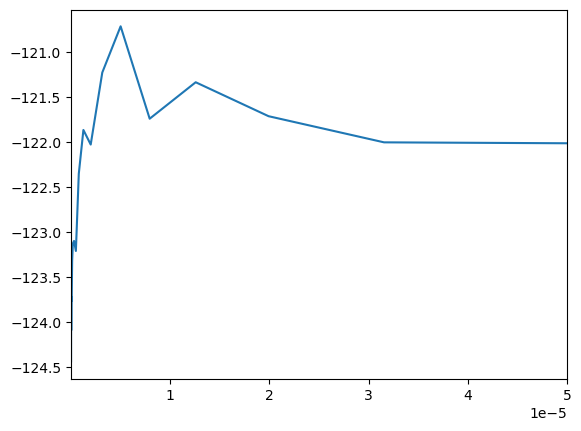

T2e_2QTII__2024_10_04__23_20_14


In [106]:
Delay = parameters["Delay"]

# Obtém a data e hora atuais
start = datetime.now()
name = start.strftime(f"{data_exp["name"]}_{data_exp["sample"]}__%Y_%m_%d__%H_%M_%S")
print(name)
howtoplot = "\
    data = np.load('"+name+".npz')\n\
    delays = data['Delay']\n\
    mags = data['Mag']\n\
    phases = data['Phase']"

alazar_params['recordsPerBuffer'] = 250  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
inst_att.set_attenuation(parameters["attenuation"])
inst_RFsourceMeasurement.set_frequency(parameters["measurement_freq"]-240e6)
#inst_RFsourceExcitation.set_frequency(4.2961e9) # mudar este aqui para o mapa de rabi gustavo: dentro do for 
inst_RFsourceMeasurement.set_amplitude(parameters["measurement_amp"])
#inst_RFsourceExcitation.set_amplitude(11)

Mag = np.full(len(Delay),np.nan)  
Phase = np.full(len(Delay),np.nan) 

inst_awg.stop()
inst_RFsourceMeasurement.stop_rf()
inst_RFsourceExcitation.stop_rf()
sleep(0.5)
# Define-se um pulso Zero
p1=PiPulse()
p2=PiOver2Pulse()


p3 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 10e-9)
s1.clear()
s1.add(p = p1, channel = 'I', delay = 0)
s1.add(p = p2, channel = 'I', delay = 0)
s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p3, channel = 'm')

ms.prepareChannelData(sequence = s1, totalExperimentDuration = 500e-6)
sleep(2)
inst_awg.freeMemory()
sleep(0.5)
ms.allocAwgMemory()
sleep(0.5)
ms.loadChannelDataToAwg('I')
sleep(0.5)
ms.loadChannelDataToAwg('m')
sleep(0.5)
ms.setInstrumentsMarker(1)
sleep(0.5)

inst_awg.start()
inst_RFsourceMeasurement.start_rf()
#inst_RFsourceExcitation.start_rf()
sleep(1)

#Loop de Medidas
pbar=tqdm(total=len(Delay))
for i, delay in enumerate(Delay):
    
    s1.clear()
    s1.add(p = p1, channel = 'I', delay = delay)
    s1.add(p = p2, channel = 'I', delay = delay)
    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p3, channel = 'm')
    
    ms.updateChannelData(sequence = s1, channelName = 'I')
    sleep(0.5)
    ms.loadChannelDataToAwg('I') # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m
    sleep(0.5)
    ms.loadChannelDataToAwg('m')
    sleep(0.5)
    ms.setInstrumentsMarker(1)
    sleep(0.5)

    I,Q = inst_alazar.capture(**alazar_params)  
    sleep(0.5)
    Mag[i] = 20*np.log(np.sqrt(I**2+Q**2))
    Phase[i] = np.arctan2(Q, I)

    # Limpa o gráfico atual
    
    clear_output(wait=True)  
    print(name)
    pbar.update(1)
    display(pbar.container)
   
    #plt.xlim(Delay[0],Delay[-1])
    #plt.plot(Delay,Mag)
    #plt.pause(0.05)

    px.line(x=Freq,y=Mag,width=600,height=600).show()
    end=datetime.now()
    np.savez(name,header=howtoplot,Mag=Mag,Phase=Phase,start=start.isoformat(),end=end.isoformat(),**parameters)
    sleep(0.05)
    
inst_RFsourceMeasurement.stop_rf()
inst_awg.stop()


In [150]:
dados = np.load('T2e_2QTII__2024_10_04__23_20_14.npz')
dados["header"]
Delay = dados['Delay']
Mag = dados['Mag']
Mag = 10**(Mag/20)
Phase = dados['Phase']
print(exp_decay.__code__.co_varnames)
#('t', 'offset', 'tau', 'amp')
fit(Delay, Mag,exp_decay, [7e-7, 1e-5, -3e-7,])

('t', 'offset', 'tau', 'amp')


({'offset': 8.37270162171593e-07,
  'tau': 8.261887264095417e-07,
  'amp': -2.0512171844413883e-07},
 {'offset': 1.2480523119424564e-08,
  'tau': 2.3765699463057143e-07,
  'amp': 1.7610303809681538e-08})

Text(0.5, 1.0, '$T_2^{echo}$ Measurement')

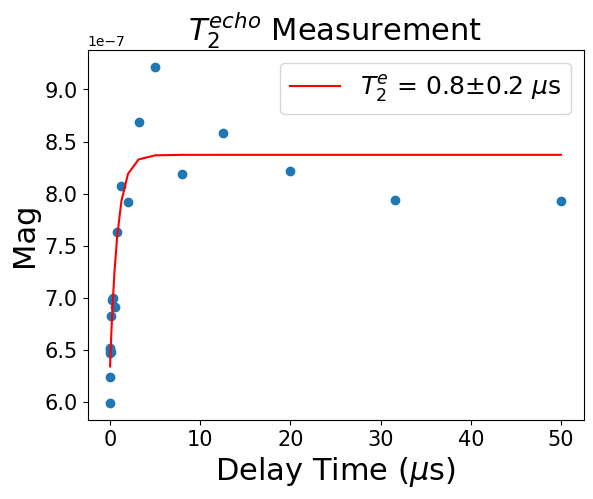

In [110]:
plt.scatter(Delay*1e6,Mag)
plt.plot(Delay*1e6,T1(Delay,*popt), label = f"$T_2^e$ = {T2}$\pm${desvT2} $\mu$s", color = "red")
plt.legend(prop={"size":18})
plt.xlabel("Delay Time ($\mu$s)", fontsize=22)
plt.xticks(fontsize = 15)
plt.ylabel("Mag", fontsize=22)
plt.yticks(fontsize = 15)
#plt.legend()
plt.title("$T_2^{echo}$ Measurement", fontsize=22)